In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
#from scipy import stats
#from scipy.stats import chi2_contingency, ks_2samp, loguniform
#from sklearn.metrics import matthews_corrcoef
#import warnings
#warnings.filterwarnings("ignore")
#import random
#import matplotlib.ticker as tkr
#from imblearn.over_sampling import SMOTENC
#from optbinning import BinningProcess

#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from sklearn.linear_model import LogisticRegression
#from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RandomizedSearchCV
#from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
#from sklearn.feature_selection import RFECV
#from xgboost import XGBClassifier

<H1> Intro <H1>

The goal of this project is to pre-process the provided data file and then create a model whose task will be to
predict outcomes for a given business case.

Our project will be implemented in accordance with the CRISP-DM (Cross Industry Standard Process for Data Mining) methodology, which is a process model that serves as the basis for data science processes and consists of six steps: Business understanding, data understanding, data preparation, modeling, model evaluation and deployment.

Within the framework of this project, we will use one tool for individual tasks - the Python programming language, both for data preparation and subsequent modeling. Python is an open source, object-oriented, high-level programming language. It is widely used due to its easy-to-understand and learnable syntax (resulting in reduced program maintenance costs). Furthermore, it supports an infinite number of modules and packages (Python Software Foundation, 2019). This is especially true for data science libraries. The most common are: NumPy, Pandas, Matplotlib, SciPy or Scikit-learn (GeeksforGeeks, 2022), which we will also use in our project.

In [2]:
# load data from git
dataset = pd.read_csv('https://raw.githubusercontent.com/Doll03/4IZ480/main/Data/TimeDeposit_10K.csv', sep=";")


<H1> Business case <H1>

Before data exploratory analysis, it is necessary to understand and define the goal of our business case. This step is necessary and mandatory for any data mining project. It usually involves identifying and describing the basic project objectives from a business perspective and then establishing a set of project objectives and requirements that are used to develop the project plan.

As this data is about a banking institution and its customers, we therefore want to create a model that will predict whether a customer will open a new term deposit.
With the help of the given model, the banking institution can not only reduce its costs to avoid targeting the wrong customers, but also increase its profits by targeting the relevant ones. In other words, we would like to classify clients according to the probability of opening a new term deposit, and based on this, the banking institution can adjust its business strategy and customer relations.

<H1>Data understanding<H1>

This step can consist of three sub-steps – data collection, data description and exploratory data analysis. With regard to data collection, this dataset was provided to us by the course professor in csv format along with a description of the dataset. The data file provided contains 46 columns and 10,000 rows, where each row represents one customer of a given bank with the information listed in the columns. In particular, this data set contains customer demographic information (such as gender, marital status, age), financial information (income, balances) and transaction information (number of transactions, transaction amounts). Lastly the last column of the dataset states whether the customer opened a new term deposit or not.

In [4]:
#change of features datatypes 
dataset["Customer_ID"] = dataset["Customer_ID"].astype("object")
dataset["Birth_Date"] = dataset["Birth_Date"].astype("datetime64")
dataset["Ref_Date"] = dataset["Ref_Date"].astype("datetime64")
dataset["Gender"] = dataset["Gender"].astype("category")
dataset["Marital_Status"] = dataset["Marital_Status"].astype("category")
dataset["Children_Num"] = dataset["Children_Num"].astype("category")
dataset["Occupation_Category"] = dataset["Occupation_Category"].astype("category")
dataset["Payroll_Flag"] = dataset["Payroll_Flag"].astype("bool")
dataset["Business_Flag"] = dataset["Business_Flag"].astype("bool")
dataset["Saving_Current_Accounts_Flag"] = dataset["Saving_Current_Accounts_Flag"].astype("bool")
dataset["Investment_Products_Flag"] = dataset["Investment_Products_Flag"].astype("bool")
dataset["Insurance_Products_Flag"] = dataset["Insurance_Products_Flag"].astype("bool")
dataset["Business_Loans_Flag"] = dataset["Business_Loans_Flag"].astype("bool")
dataset["Housing_Loans_Flag"] = dataset["Housing_Loans_Flag"].astype("bool")
dataset["Consumer_Loans_Flag"] = dataset["Consumer_Loans_Flag"].astype("bool")
dataset["Credit_Cards_Flag"] = dataset["Credit_Cards_Flag"].astype("bool")
dataset["Time_Deposits_Flag"] = [True if i == "T" else False for i in dataset['Time_Deposits_Flag']]



In [6]:
#Creating boolean features 
dataset["Credit_Cards_Installments_Flag"] = [True if i > 0 else False for i in dataset['Credit_Cards_Installments']]
dataset["Credit_Cards_Payments_Flag"] = [True if i > 0 else False for i in dataset['Credit_Cards_Payments_Num']]
dataset["Credit_Cards_Purchases_Flag"] = [True if i > 0 else False for i in dataset['Credit_Cards_Purchases_Num']]
dataset["Credit_Cards_Witrhdrawals_Flag"] = [True if i > 0 else False for i in dataset['Credit_Cards_Witrhdrawals_Num']]
dataset["Internet_Trans_Flag"] = [True if i > 0 else False for i in dataset['Internet_Trans_Num']]
dataset["Deposit_Trans_Flag"] = [True if i > 0 else False for i in dataset['Deposit_Trans_Num']]
dataset["Payment_Trans_Flag"] = [True if i > 0 else False for i in dataset['Payment_Trans_Num']]
dataset["Transfer_Trans_Flag"] = [True if i > 0 else False for i in dataset['Transfer_Trans_Num']]
dataset["Withdrawl_Trans_Flag"] = [True if i > 0 else False for i in dataset['Withdrawl_Trans_Num']]

Before starting the exploratory analysis of features, we decided to change one of them to different datatype. Feature age was changed into categorical variable with 4 bins, which were found thanks to optimal binning process.

In [7]:
#Creating feature Age_Cat
dataset['Age'] = dataset['Ref_Date'].dt.year - dataset['Birth_Date'].dt.year
Age_Cat = pd.cut(dataset['Age'], bins=[0, 32.50, 51.50, 60.50, 150],labels=['Younger', 'LowerMid', 'UpperMid', 'Older'])
Age_Cat

0       LowerMid
1       LowerMid
2       UpperMid
3       UpperMid
4       LowerMid
          ...   
9995     Younger
9996    LowerMid
9997    LowerMid
9998    LowerMid
9999     Younger
Name: Age, Length: 10000, dtype: category
Categories (4, object): ['Younger' < 'LowerMid' < 'UpperMid' < 'Older']

In the following graph, we can see the distribution of the target variable Time_Deposits_Flag, according to which the target variable is heavily imbalanced. If this issue will not be treated, the model would focus primarily on the majority class instead and might bias the predictions.
This issue can be dealt with oversampling and/or undersampling. One might use the Random Oversampling/Undersampling where we randomly duplicate examples in the minority class, whereas undersampling is about deleting examples in the majority class randomly (Brownlee, 2020). However, since this technique duplicates the examples, it would tend to the overfitting, therefore, the Random Oversampling will not be used. With regards to the undersampling technique, this will not be used either since we would lose significant amount of information by removing the instances with the majority class.


<H1>Exploratory analysis<H1>

False    0.9897
True     0.0103
Name: Time_Deposits_Flag, dtype: float64


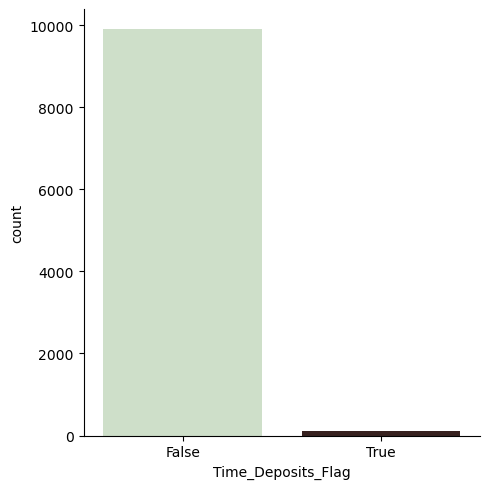

In [8]:
# show histogram of target variable
print(dataset["Time_Deposits_Flag"].value_counts(normalize=True))
sns.catplot(data = dataset, x = "Time_Deposits_Flag", kind = "count", palette = "ch:.79")
plt.show()

In [9]:
#change of target datatype
dataset['Time_Deposits_Flag']=dataset['Time_Deposits_Flag'].astype('category')

In [10]:
# dropping unnecessary variables
dataset = dataset.drop(["Ref_Date","Birth_Date","Customer_ID","Age" ], axis = "columns", errors="ignore")

In [11]:
#crealing list of categorical features
cat_v_list = [i for i in list(dataset.columns) if (dataset[i].dtypes in ['O', 'bool', "category"])]
cat_v_list.remove('Time_Deposits_Flag')

#creating list of numerical features
num_v_list = [i for i in list(dataset.columns) if i not in cat_v_list]
num_v_list.remove('Time_Deposits_Flag')
print("Num:", num_v_list, "end=", "Cat:", cat_v_list)


Num: ['Total_Income', 'Saving_Current_Balance', 'Investment_Products_Balance', 'Insurance_Balances', 'Business_Loans_Balance', 'Housing_Loans_Balance', 'Consumer_Loans_Balance', 'Credit_Cards_Balance', 'Branch_Trans_Num', 'ATM_Trans_Num', 'APS_Trans_Num', 'Phone_Trans_Num', 'Internet_Trans_Num', 'Deposit_Trans_Num', 'Withdrawl_Trans_Num', 'Payment_Trans_Num', 'Transfer_Trans_Num', 'Deposit_Trans_Amount', 'Withdrawl_Trans_Amount', 'Payment_Trans_Amount', 'Transfer_Trans_Amount', 'Credit_Cards_Installments', 'Credit_Cards_Payments_Num', 'Credit_Cards_Purchases_Num', 'Credit_Cards_Witrhdrawals_Num', 'Credit_Cards_Payments_Amount', 'Credit_Cards_Purchases_Amount', 'Credit_Cards_Witrhdrawals_Amount', 'Arrears_Months_Max'] end= Cat: ['Gender', 'Marital_Status', 'Children_Num', 'Occupation_Category', 'Payroll_Flag', 'Business_Flag', 'Saving_Current_Accounts_Flag', 'Investment_Products_Flag', 'Insurance_Products_Flag', 'Business_Loans_Flag', 'Housing_Loans_Flag', 'Consumer_Loans_Flag', 'Credit

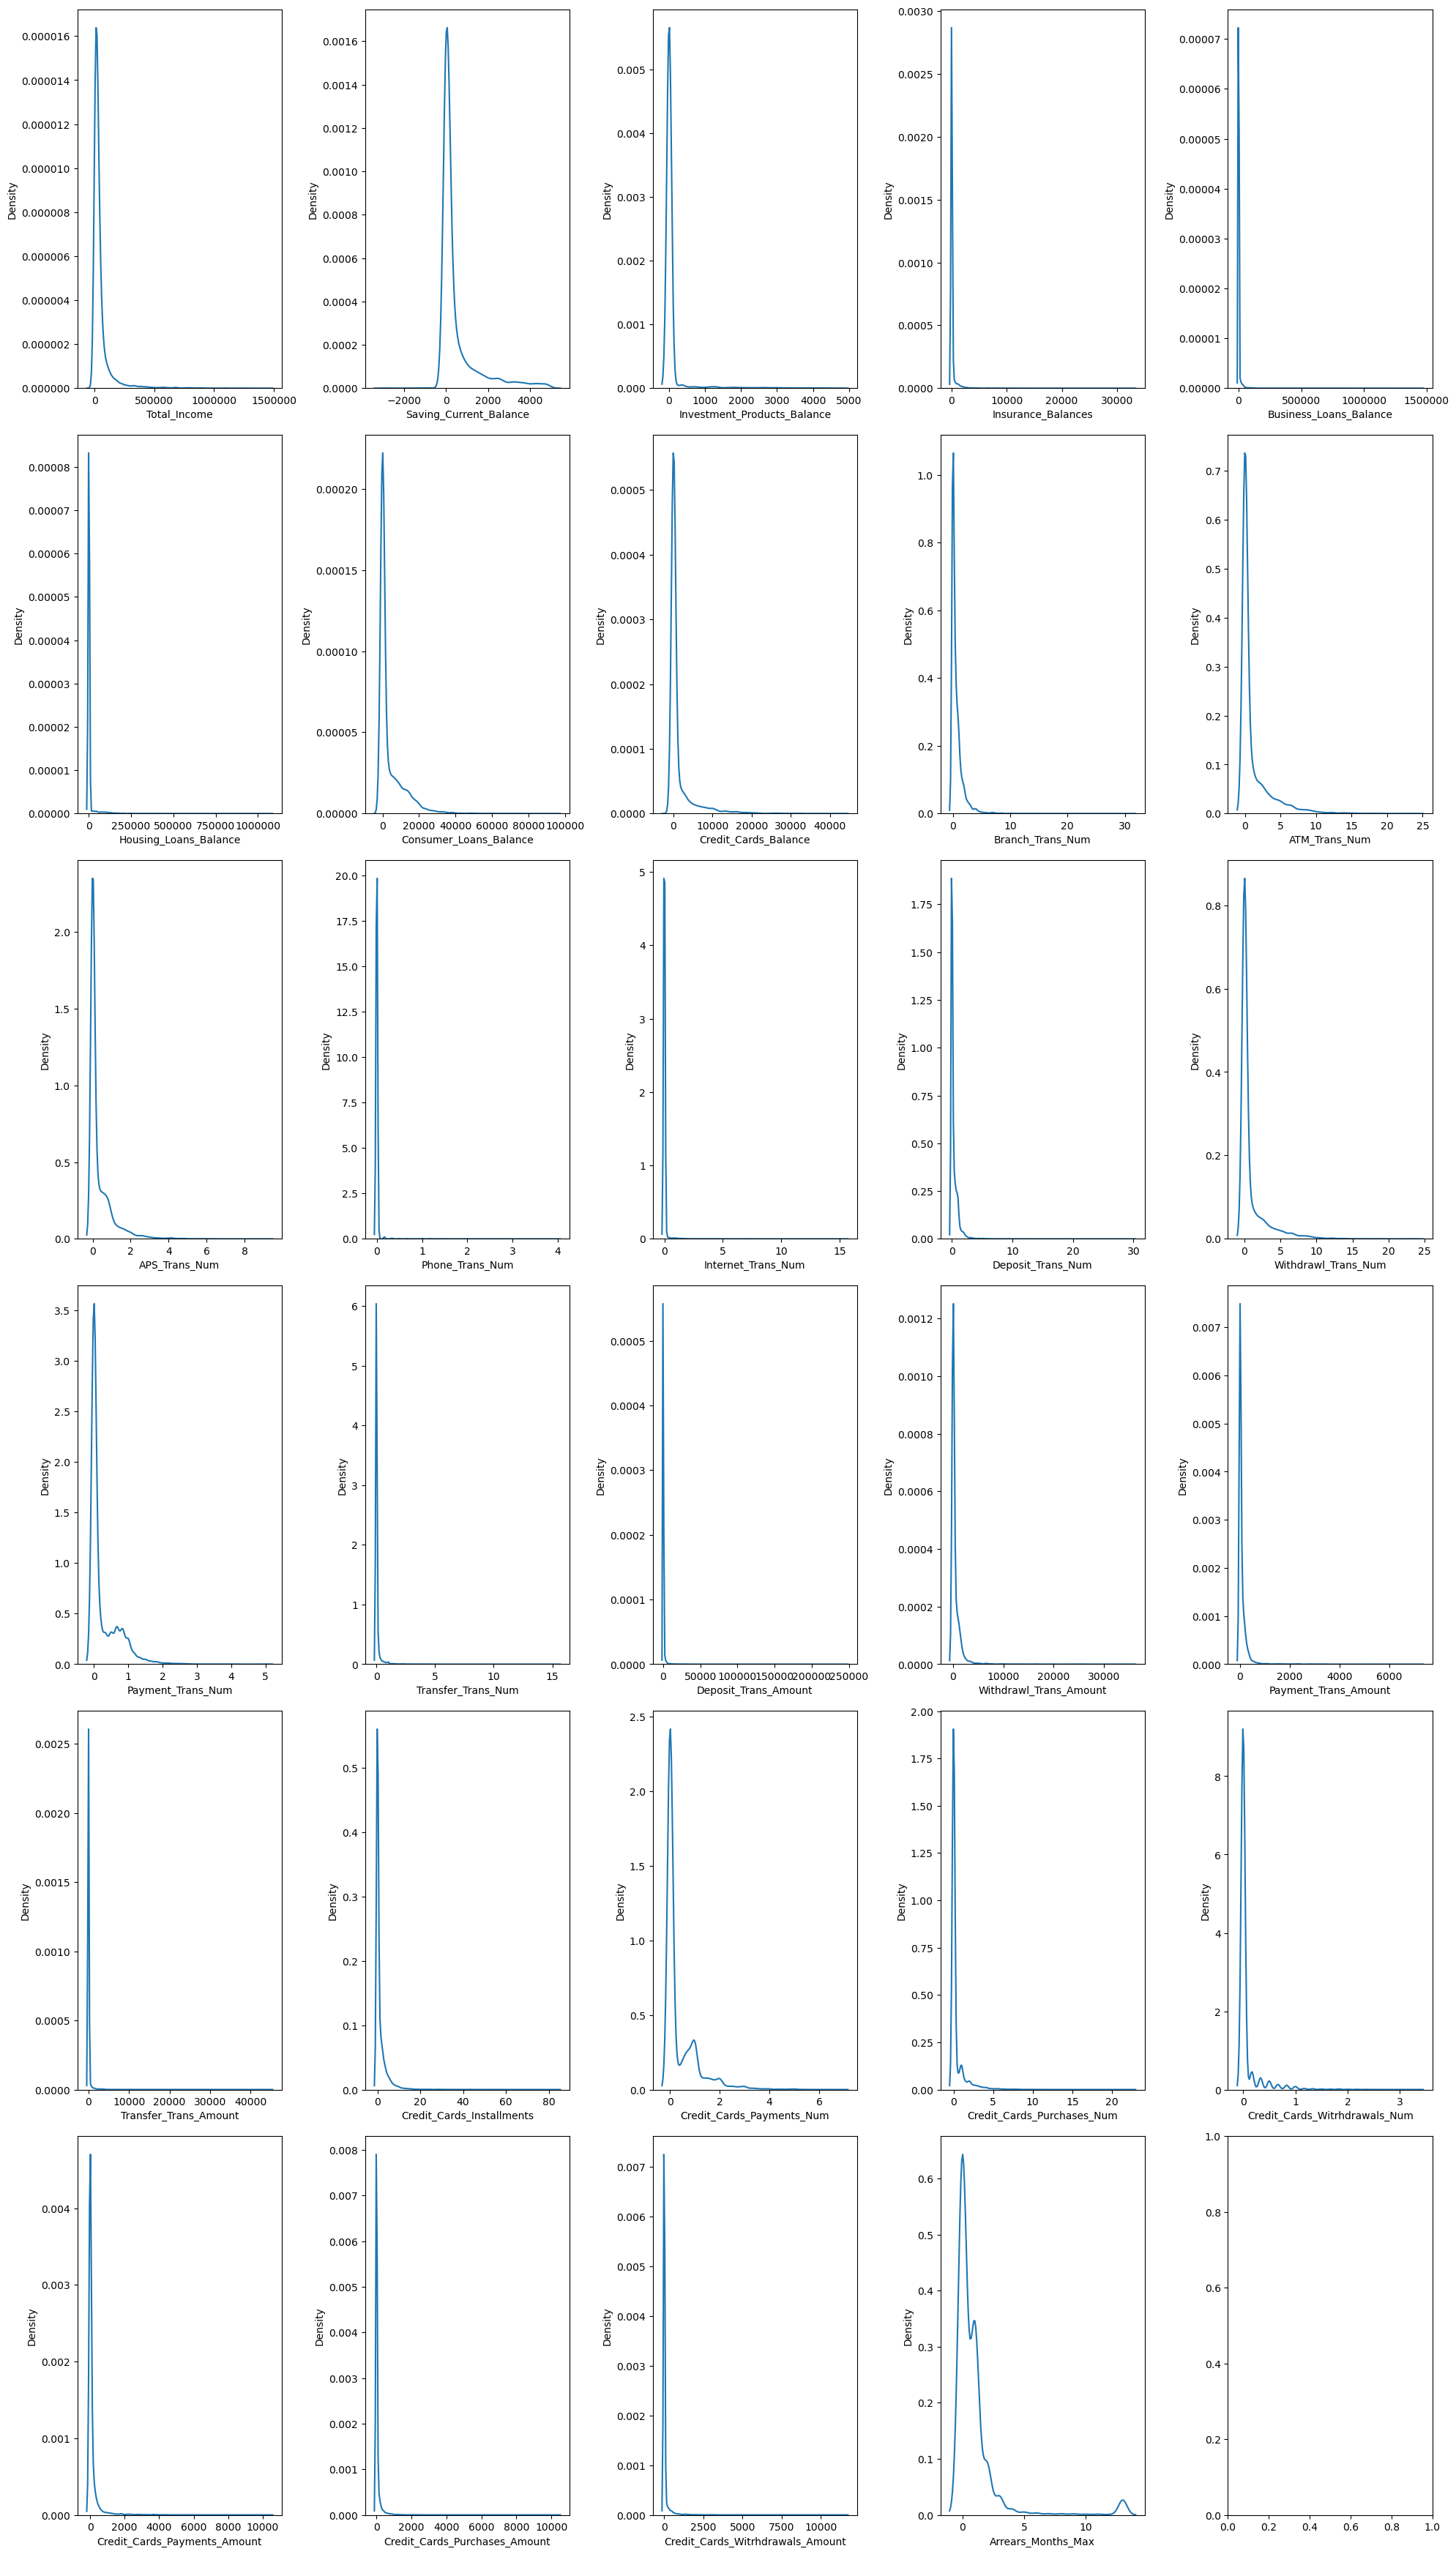

In [12]:
fig, axs = plt.subplots(6,5, figsize = (20, 35))
for i, ax in zip(num_v_list, axs.ravel()):

        sns.kdeplot(data = dataset, x = i ,ax = ax)
        ax.ticklabel_format(style = "plain", axis= "x")
        ax.ticklabel_format(style = "plain", axis= "y")

plt.tight_layout()
plt.show()        

c:\Users\Lenovo\anaconda3\envs\peterko_data_scientist\lib\site-packages\seaborn\categorical.py:641: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  grouped_vals = vals.groupby(grouper)
c:\Users\Lenovo\anaconda3\envs\peterko_data_scientist\lib\site-packages\seaborn\categorical.py:641: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  grouped_vals = vals.groupby(grouper)


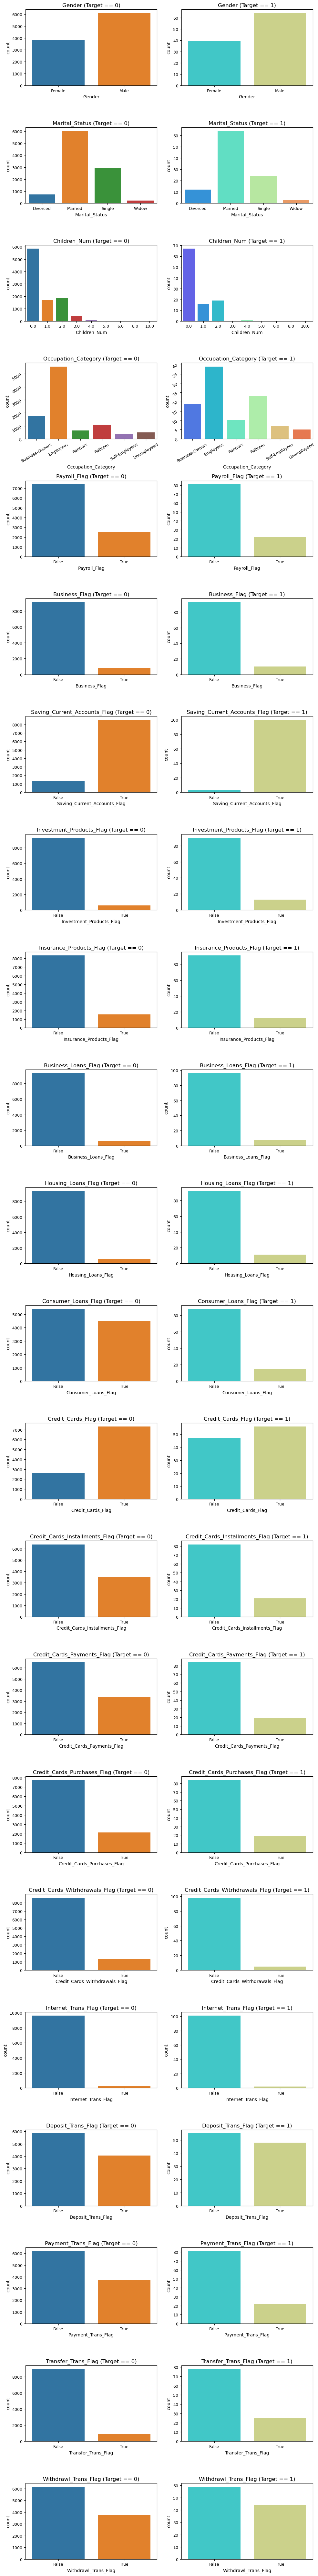

In [13]:
#Creating  graphs for categorical features.


figure,axis = plt.subplots(22,2, figsize=(10,80))

col_ind=0
axis_count = 0

for ax in axis.ravel():

    if axis_count % 2 == 0:
        sns.countplot(data=dataset[dataset["Time_Deposits_Flag"] == False], x=cat_v_list[col_ind], ax = ax)
        ax.set_title(cat_v_list[col_ind]+" (Target == 0)")

        if cat_v_list[col_ind] == "Occupation_Category":
            ax.tick_params(axis='both', which='major', labelsize=9, rotation = 30)
        else:
            ax.tick_params(axis='both', which='major', labelsize=9)
        
    else:
        sns.countplot(data=dataset[dataset["Time_Deposits_Flag"] == True], x=cat_v_list[col_ind], ax = ax, palette='rainbow')
        ax.set_title(cat_v_list[col_ind]+" (Target == 1)")

        if cat_v_list[col_ind] == "Occupation_Category":
            ax.tick_params(axis='both', which='major', labelsize=9, rotation = 30)
        else:
            ax.tick_params(axis='both', which='major', labelsize=9)

        col_ind += 1
        
    axis_count +=1

plt.tight_layout()
plt.show()

In [14]:
list(dataset[cat_v_list].describe().transpose().index)

['Gender',
 'Marital_Status',
 'Children_Num',
 'Occupation_Category',
 'Payroll_Flag',
 'Business_Flag',
 'Saving_Current_Accounts_Flag',
 'Investment_Products_Flag',
 'Insurance_Products_Flag',
 'Business_Loans_Flag',
 'Housing_Loans_Flag',
 'Consumer_Loans_Flag',
 'Credit_Cards_Flag',
 'Credit_Cards_Installments_Flag',
 'Credit_Cards_Payments_Flag',
 'Credit_Cards_Purchases_Flag',
 'Credit_Cards_Witrhdrawals_Flag',
 'Internet_Trans_Flag',
 'Deposit_Trans_Flag',
 'Payment_Trans_Flag',
 'Transfer_Trans_Flag',
 'Withdrawl_Trans_Flag']

In [14]:
# creating contingency table for categorical features

cat_vars = list(dataset[cat_v_list].describe().transpose().index)+["Time_Deposits_Flag"]

for i in cat_vars:
    dataset[i] = dataset[i].astype("category")
cat_corr_mat = pd.DataFrame(columns = cat_vars, index = cat_vars)

for row in cat_corr_mat.index:
    for col in cat_corr_mat.columns:
        if (dataset[row].nunique() == 2) and ((dataset[col].nunique() == 2)):
            try:
                bin_var1 = dataset[col].astype("int")
            except:
                bin_var1 = [True if i == dataset[col].unique()[0] else False for i in dataset[col]]
            try:
               bin_var2 = dataset[row].astype("int")
            except:
                bin_var2 = [True if i == dataset[row].unique()[0] else False for i in dataset[row]]
            phi = matthews_corrcoef(bin_var1, bin_var2)
            cat_corr_mat.loc[row, col] = phi
        elif (dataset[row].nunique() > 2) or ((dataset[col].nunique() > 2)):
            data_crosstab = pd.crosstab(dataset[row], dataset[col])
            chi2, _, ___, ____ = chi2_contingency(data_crosstab, correction=False)
            cramer = np.sqrt(chi2/data_crosstab.sum().sum())/ (min(data_crosstab.shape) -1)
            cat_corr_mat.loc[row, col] = cramer
cat_corr_mat

,Gender,Marital_Status,Children_Num,Occupation_Category,Payroll_Flag,Business_Flag,Saving_Current_Accounts_Flag,Investment_Products_Flag,Insurance_Products_Flag,Business_Loans_Flag,...,Credit_Cards_Installments_Flag,Credit_Cards_Payments_Flag,Credit_Cards_Purchases_Flag,Credit_Cards_Witrhdrawals_Flag,Internet_Trans_Flag,Deposit_Trans_Flag,Payment_Trans_Flag,Transfer_Trans_Flag,Withdrawl_Trans_Flag,Time_Deposits_Flag
Gender,1.0,0.064373,0.052235,0.088933,-0.087323,0.068738,0.044005,-0.022863,0.016285,0.078136,...,-0.013426,-0.012614,-0.048326,0.032302,0.028005,0.052559,0.034361,0.013492,-0.031664,0.001166
Marital_Status,0.064373,0.57735,0.173188,0.113375,0.114699,0.071486,0.060302,0.062563,0.085872,0.071439,...,0.058731,0.057558,0.044857,0.045673,0.043344,0.041945,0.066488,0.025355,0.087918,0.020579
Children_Num,0.052235,0.173188,0.353553,0.048478,0.057933,0.085864,0.021147,0.04967,0.042345,0.086147,...,0.01945,0.024095,0.022199,0.026121,0.031198,0.036504,0.043598,0.021858,0.046676,0.023089
Occupation_Category,0.088933,0.113375,0.048478,0.447214,0.261287,0.441029,0.038752,0.03605,0.027344,0.367203,...,0.049781,0.04648,0.060642,0.032671,0.052749,0.0962,0.088957,0.084033,0.093773,0.047744
Payroll_Flag,-0.087323,0.114699,0.057933,0.261287,1.0,-0.142585,0.195449,-0.077686,-0.076329,-0.119432,...,-0.008279,-0.011377,0.031625,-0.015285,0.050607,-0.081752,-0.174675,0.066307,0.473583,-0.009047
Business_Flag,0.068738,0.071486,0.085864,0.441029,-0.142585,1.0,0.044922,-0.031689,0.017548,0.819254,...,0.014841,0.016234,0.007118,-0.001109,0.035679,0.197719,0.077114,0.130637,0.041843,0.006882
Saving_Current_Accounts_Flag,0.044005,0.060302,0.021147,0.038752,0.195449,0.044922,1.0,-0.137847,0.003624,0.019021,...,-0.111922,-0.113728,-0.052955,-0.058257,0.044237,0.285265,-0.076845,0.117019,0.260883,0.031567
Investment_Products_Flag,-0.022863,0.062563,0.04967,0.03605,-0.077686,-0.031689,-0.137847,1.0,-0.033754,-0.033247,...,-0.097566,-0.091781,-0.057283,-0.068446,0.016236,-0.07903,-0.113187,0.024982,-0.055134,0.027479
Insurance_Products_Flag,0.016285,0.085872,0.042345,0.027344,-0.076329,0.017548,0.003624,-0.033754,1.0,0.019994,...,0.16751,0.164325,0.103446,0.176589,0.024519,0.142576,0.264598,0.078019,-0.011969,-0.01133
Business_Loans_Flag,0.078136,0.071439,0.086147,0.367203,-0.119432,0.819254,0.019021,-0.033247,0.019994,1.0,...,0.010976,0.013839,0.003071,0.008567,0.019186,0.206965,0.092475,0.101596,0.039682,0.004347


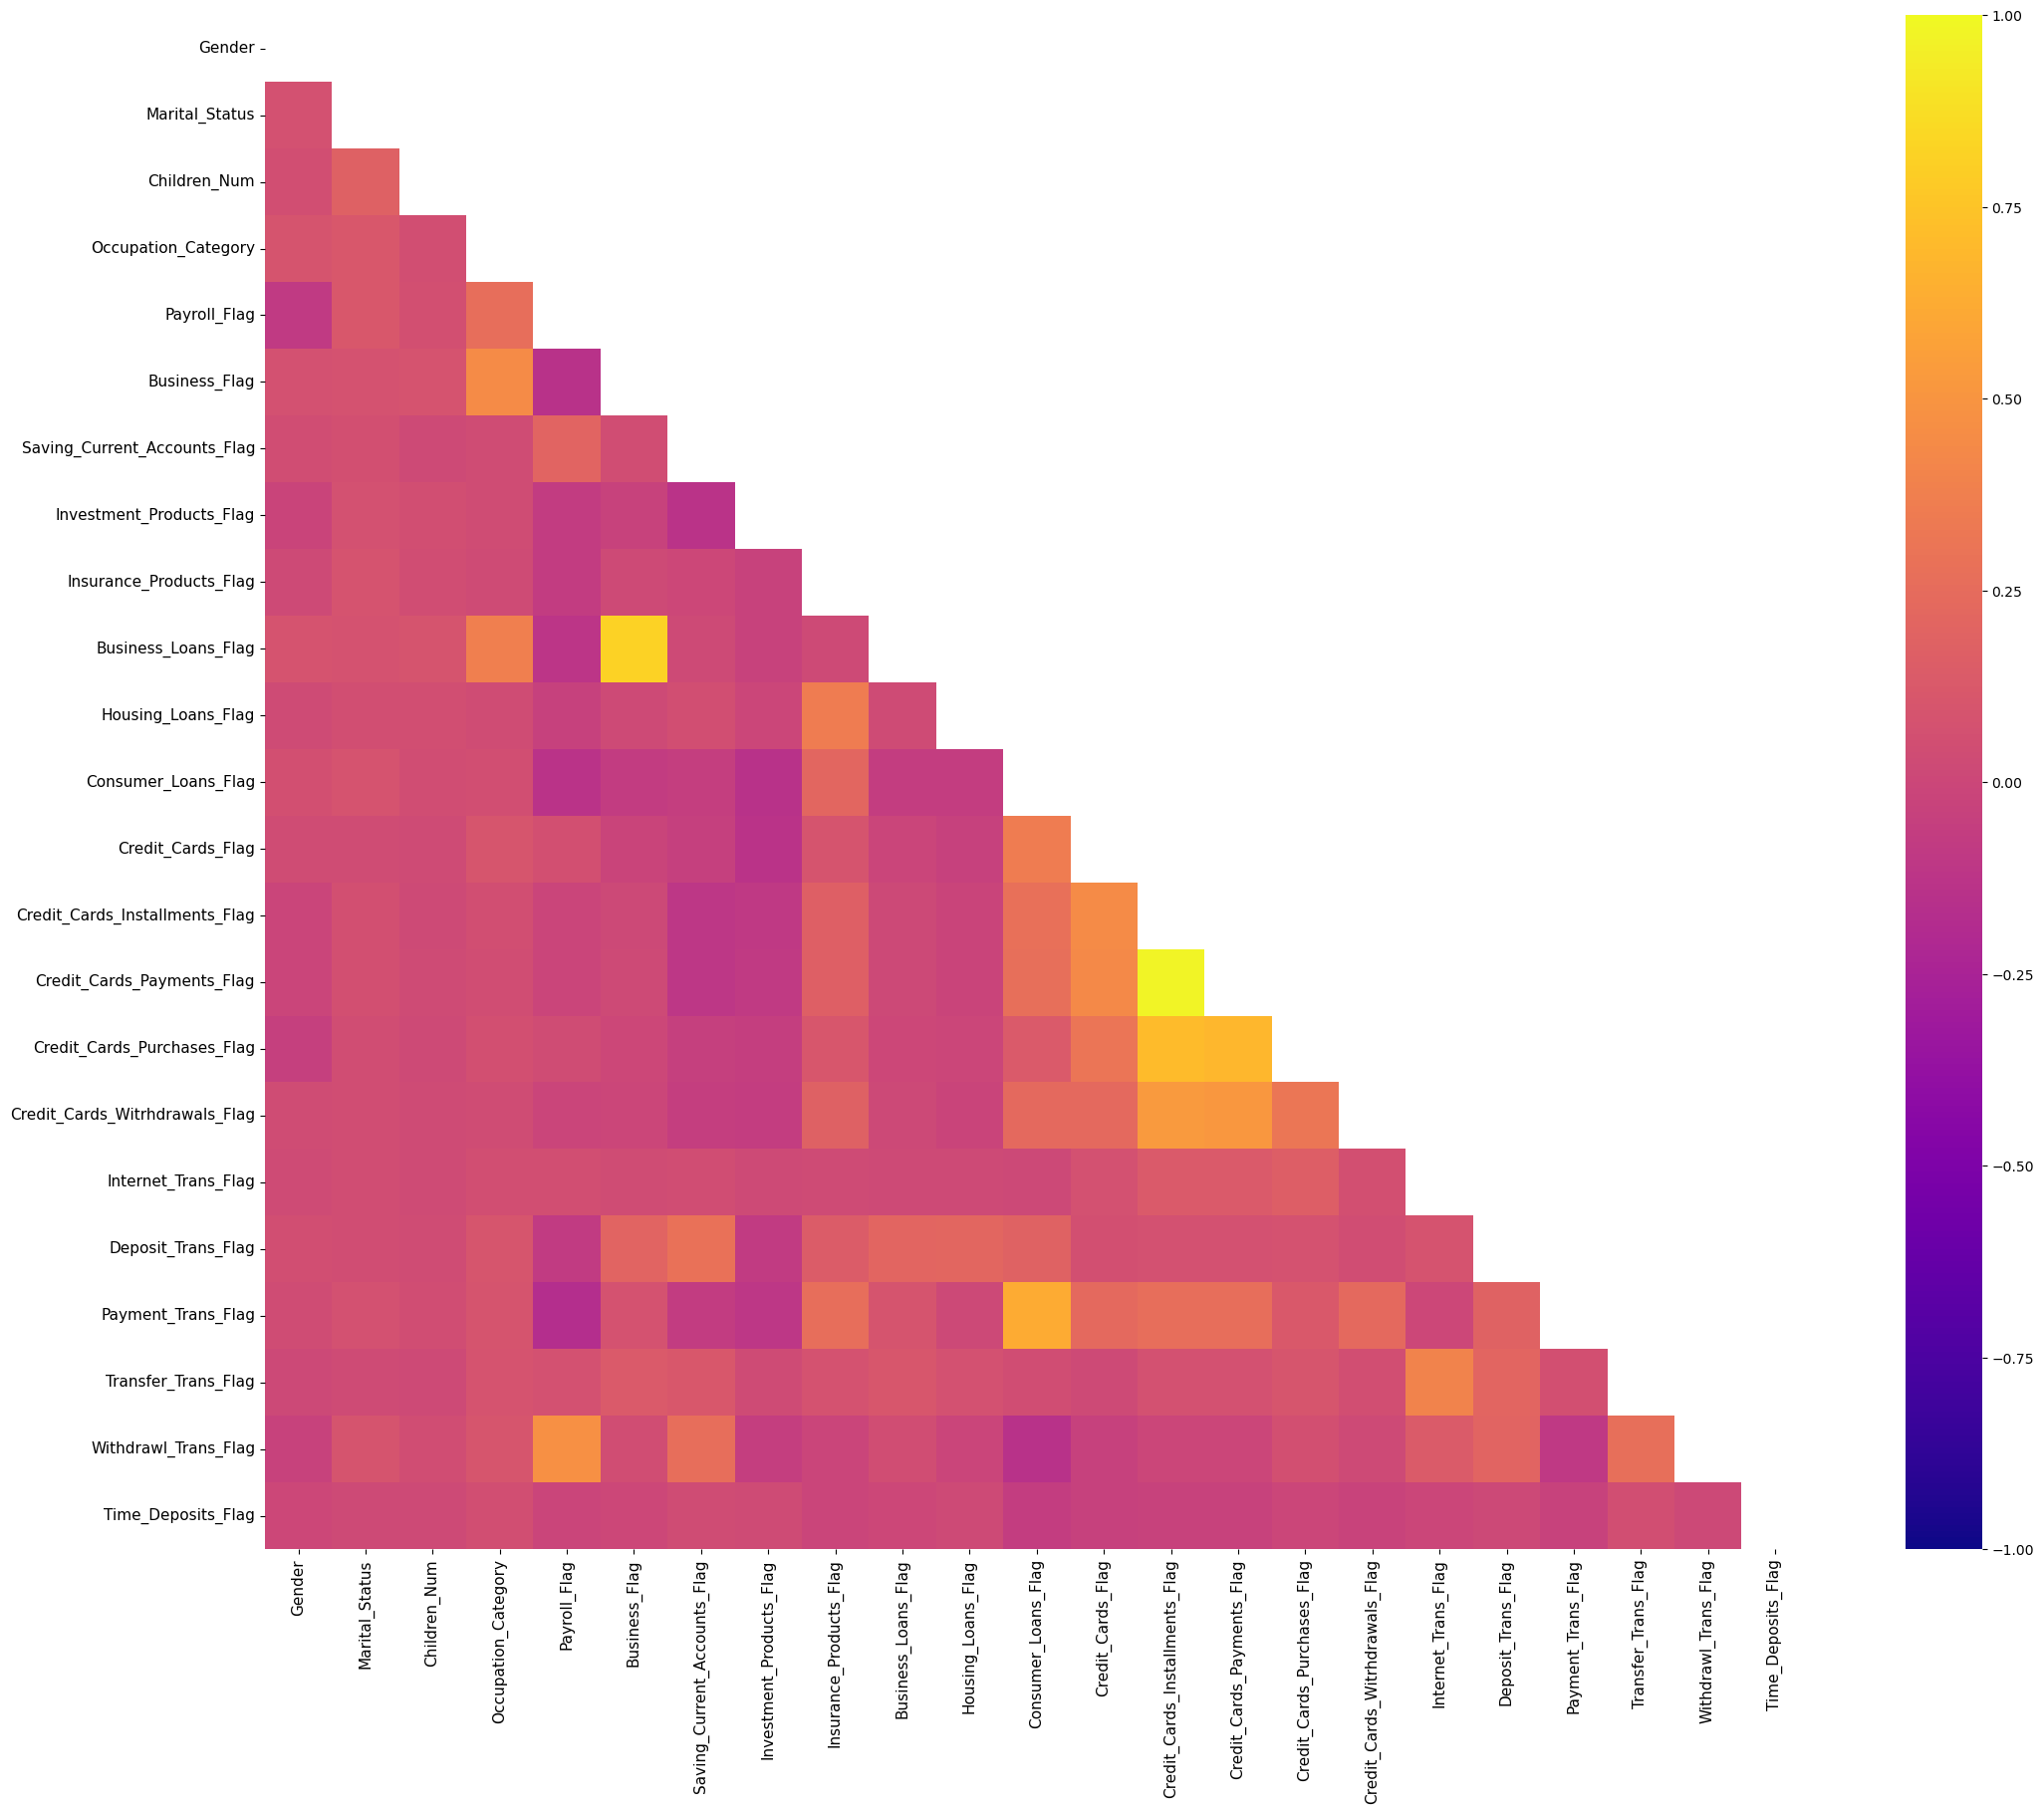

In [15]:
#creating heatmap for category features
cat_corr_mat = cat_corr_mat.astype("float")
plt.figure(figsize = (25, 20))
mask = np.triu(np.ones_like(cat_corr_mat))
cax = sns.heatmap(cat_corr_mat, vmin = -1, vmax = 1, mask = mask, cmap = "plasma")
cax.tick_params(labelsize = 11)
plt.show()


In [16]:
#function for displaying contigency table and chi-square statistic

def chi_square(data, var1, var2 = "Time_Deposits_Flag", alpha = 0.05):


    data_crosstab = pd.crosstab(data[var1],data[var2], margins=True)

    chi2, p, dof, expected = chi2_contingency(data_crosstab, correction=False)

    print('The p-value is', p)
    print(expected)
    if p <= alpha:
        print(f'Result: We reject the null hypothesis: There is a relationship between {var1} and {var2}, therefore they are dependent.')
    else:
        print(f'Result: We fail to reject the null hypothesis: There is no relationship between {var1} and {var2}, therefore they are independent.')
    return data_crosstab

chi_square(dataset, "Gender")

The p-value is 0.9999770029434877
[[ 3802.4274    39.5726  3842.    ]
 [ 6094.5726    63.4274  6158.    ]
 [ 9897.       103.     10000.    ]]
Result: We fail to reject the null hypothesis: There is no relationship between Gender and Time_Deposits_Flag, therefore they are independent.


Time_Deposits_Flag,False,True,All
Gender,,,
Female,3803,39,3842
Male,6094,64,6158
All,9897,103,10000


In [19]:
seed = 33

<H1>Data Split<H1>

In [20]:
# dataset division into features and target
target = dataset["Time_Deposits_Flag"]
feature = dataset.drop("Time_Deposits_Flag", axis= 1)

variable_names = list(feature.columns[:])

X = dataset[variable_names]
y = dataset["Time_Deposits_Flag"]

In [21]:
#dataset division into training, testing and validation dataset
_, X_test, __, y_test = train_test_split(X, y, test_size=0.15, random_state = seed, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(_, __, test_size=0.1764, random_state = seed, stratify=__)

In [22]:
#control of equal division into the datasets
print("X_test", X_test.shape[0])
print("y_test", y_test.shape[0])
print("X_train", X_train.shape[0])
print("y_train", y_train.shape[0])
print("X_valid", X_valid.shape[0])
print("y_valid", y_valid.shape[0])


X_test 1500
y_test 1500
X_train 7000
y_train 7000
X_valid 1500
y_valid 1500


<H1>Oversampling<H1>

In [23]:
#zvazovali jsme i underampling ale matematicky to vychazi napicu. Abychom z rozlozeni 99/1 udelali alespon 90/10 stratili bychom 90% pozorování

In [24]:
#column indexing
cat_index = [ind for ind, i in enumerate(X_train.columns) if i in cat_v_list]
cat_index

[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 42, 43, 44, 45, 46, 47, 48, 49, 50]

In [25]:
#aby fungoval smotenc musím převst na dataframe a as type integer
y_train = pd.DataFrame(y_train)
y_train = y_train.astype("int")

In [26]:
y_train.value_counts()

Time_Deposits_Flag
0                     6928
1                       72
dtype: int64

In [27]:
#datatype change to objects
for i in cat_v_list:
    X_train[i] = X_train[i].astype("O")

In [76]:
#samotnej oversampling, k-near neighbours is 5 by default
#Synthetic Minority Over-sampling Technique for Nominal and Continuous
smotenc = SMOTENC(random_state=seed, categorical_features=cat_index)
X_respl, y_respl = smotenc.fit_resample(X_train, pd.DataFrame(y_train))

In [29]:
# check of oversampling 
y_respl.value_counts()

Time_Deposits_Flag
0                     6928
1                     6928
dtype: int64

In [30]:
y_respl = y_respl["Time_Deposits_Flag"]

In [31]:
#Defining the binning process
bn = BinningProcess(list(X_respl.columns), categorical_variables = cat_v_list)
bn.fit(X_respl, y_respl)

#Transform
X_train_binned = bn.transform(X_respl, metric="woe")
X_valid_binned = bn.transform(X_valid, metric="woe")
X_test_binned = bn.transform(X_test, metric="woe")

#Storing
woe_bins = pd.DataFrame()
for i in X_train_binned.columns:
    var = bn.get_binned_variable(i).binning_table.build()
    var = var[(~var["Bin"].isin(["Special", "Missing"])) & (~var.index.isin(["Totals"]))]
    var["Variable"] = i
    woe_bins = pd.concat((woe_bins, var))

In [33]:
# list of all the bins
woe_bins

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Variable
0,[Female],4609,0.332636,2637,1972,0.427859,0.290594,0.027893,0.003474,Gender
1,[Male],9247,0.667364,4291,4956,0.535958,-0.144079,0.013830,0.001727,Gender
0,"[Widow, Divorced]",798,0.057592,666,132,0.165414,1.618488,0.124751,0.014088,Marital_Status
1,[Single],3127,0.225678,2059,1068,0.341541,0.656433,0.093898,0.011531,Marital_Status
2,[Married],9931,0.716729,4203,5728,0.576780,-0.309568,0.068142,0.008484,Marital_Status
...,...,...,...,...,...,...,...,...,...,...
1,[False],10841,0.782405,4316,6525,0.601882,-0.413312,0.131785,0.016357,Payment_Trans_Flag
0,[True],926,0.066830,666,260,0.280778,0.940608,0.055122,0.006647,Transfer_Trans_Flag
1,[False],12930,0.933170,6262,6668,0.515700,-0.06282,0.003681,0.000460,Transfer_Trans_Flag
0,[True],4369,0.315315,2619,1750,0.400549,0.403177,0.050572,0.006279,Withdrawl_Trans_Flag


In [34]:
# features where number of bins = 1
list(pd.DataFrame(woe_bins["Variable"].value_counts()).query("Variable==1").index)

['Phone_Trans_Num',
 'Business_Loans_Flag',
 'Investment_Products_Flag',
 'Internet_Trans_Flag',
 'Business_Flag',
 'Internet_Trans_Num']

In [35]:
# dropping features where number of bins = 1 from all datasets
X_train_binned.drop(list(pd.DataFrame(woe_bins["Variable"].value_counts()).query("Variable==1").index), axis = 1, errors = "ignore")
X_valid_binned.drop(list(pd.DataFrame(woe_bins["Variable"].value_counts()).query("Variable==1").index), axis = 1, errors = "ignore")
X_test_binned.drop(list(pd.DataFrame(woe_bins["Variable"].value_counts()).query("Variable==1").index), axis = 1, errors = "ignore")

,Gender,Marital_Status,Children_Num,Occupation_Category,Total_Income,Payroll_Flag,Saving_Current_Accounts_Flag,Insurance_Products_Flag,Housing_Loans_Flag,Consumer_Loans_Flag,...,Credit_Cards_Witrhdrawals_Amount,Arrears_Months_Max,Credit_Cards_Installments_Flag,Credit_Cards_Payments_Flag,Credit_Cards_Purchases_Flag,Credit_Cards_Witrhdrawals_Flag,Deposit_Trans_Flag,Payment_Trans_Flag,Transfer_Trans_Flag,Withdrawl_Trans_Flag
0,-0.144079,1.618488,-0.301076,-0.840082,1.035811,1.807703,-0.144546,-0.101639,0.009540,-0.563963,...,-0.084149,-0.180539,-0.386210,-0.392096,-0.199384,-0.141902,0.931612,-0.413312,-0.062820,0.403177
1,-0.144079,-0.309568,0.093708,0.099731,0.581692,1.807703,-0.144546,-0.101639,0.009540,-0.563963,...,-0.084149,-0.180539,-0.386210,-0.392096,-0.199384,-0.141902,-0.355125,-0.413312,-0.062820,0.403177
2,-0.144079,-0.309568,1.596897,0.099731,1.035811,-0.241627,-0.144546,-0.101639,0.009540,-0.563963,...,-0.084149,-0.180539,-0.386210,-0.392096,-0.199384,-0.141902,-0.355125,-0.413312,-0.062820,-0.183713
3,-0.144079,1.618488,-0.301076,0.099731,0.251639,-0.241627,-0.144546,-0.101639,0.009540,2.353595,...,-0.084149,2.161359,1.898875,2.458834,1.654196,-0.141902,0.931612,-0.413312,-0.062820,-0.183713
4,-0.144079,-0.309568,-0.301076,0.099731,-0.283665,-0.241627,-0.144546,-0.101639,0.009540,-0.563963,...,-0.084149,-0.180539,-0.386210,-0.392096,-0.199384,-0.141902,-0.355125,-0.413312,-0.062820,0.403177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.290594,-0.309568,-0.301076,0.099731,0.251639,1.807703,-0.144546,-0.101639,0.009540,-0.563963,...,-0.084149,-0.180539,1.898875,2.458834,1.654196,-0.141902,-0.355125,1.868935,-0.062820,0.403177
1496,-0.144079,-0.309568,1.596897,0.236926,-0.754867,-0.241627,-0.144546,0.856858,-0.144774,2.353595,...,-0.084149,2.161359,1.898875,2.458834,-0.199384,-0.141902,0.931612,1.868935,-0.062820,-0.183713
1497,0.290594,-0.309568,-0.301076,0.099731,-0.754867,-0.241627,-0.144546,0.856858,0.009540,2.353595,...,1.187380,-0.087917,1.898875,2.458834,1.654196,5.438079,0.931612,1.868935,0.940608,0.403177
1498,0.290594,-0.309568,1.596897,0.236926,-0.283665,-0.241627,-0.144546,-0.101639,0.009540,-0.563963,...,-0.084149,-0.180539,-0.386210,-0.392096,-0.199384,-0.141902,-0.355125,-0.413312,-0.062820,-0.183713


<H1>Opt<H1>

In [36]:
#change of datatype back to "category" 
for i in cat_v_list:
    X_respl[i] = X_respl[i].astype("category")

y_respl = y_respl.astype("category")

In [37]:
y_respl = y_respl.values.tolist()


In [39]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=seed)

In [40]:
dt = DecisionTreeClassifier(random_state = seed)
rf = RandomForestClassifier(random_state = seed)
lr = LogisticRegression(random_state = seed)
gb = GradientBoostingClassifier(random_state = seed)


In [41]:
#creating dictionaries for possible models
model_dict = {'Decision Tree Classifier':dt, "Random Forest Classifier":rf, "Logistic Regression":lr, "Gradient Boosting Classifier":gb}

In [56]:
#Hyperparameter space - Logistic regression
lr_space = dict()
lr_space['solver'] = ['newton-cg', 'lbfgs', 'liblinear', "sag", "saga"]
lr_space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
lr_space['C'] = loguniform(1e-5, 1000)
#lr_space["fit_intercept"] = True

In [43]:
#Hyperparameter space - Decision Tree
dt_space = dict()
dt_space["criterion"] = ["gini", "entropy", "log_loss"]
dt_space["max_depth"] = list(range(4,50,2))
dt_space["max_features"] = list(range(2,30,2)) + ["auto", "sqrt", "log2"]


In [44]:
#Hyperparameter space - Random Forest
rf_space = dict()
rf_space["criterion"] = ["gini", "entropy", "log_loss"]
rf_space["max_depth"] = list(range(4,50,2))
rf_space["max_features"] = list(range(2,30,2)) + ["auto", "sqrt", "log2"]
rf_space["n_estimators"] = list(range(100,1000,50))

In [65]:
#Hyperparameter space - Gradient Boosting
gb_space = dict()
gb_space["max_depth"] = list(range(4,50,2))
gb_space["max_features"] = list(range(2,30,2)) + ["auto", "sqrt", "log2"]
gb_space["n_estimators"] = list(range(100,1000,50))
gb_space["loss"] = ["log_loss", "deviance", "exponential"]
gb_space["criterion"] = ["friedman_mse", "mse", "squared_error"]
gb_space["learning_rate"] = list(np.arange(0.001, 100, 0.01))


In [107]:
X_train = X_train_binned
y_train = y_respl
y_valid = y_valid.astype("int")


In [66]:
#Random_Forest
r_search_rf = RandomizedSearchCV(estimator = rf, param_distributions= rf_space , random_state=seed, scoring = "roc_auc")
rs_rf_fit= r_search_rf.fit(X_train, y_train)
rs_rf_param = rs_rf_fit.best_params_


#Decision_Tree
r_search_dt = RandomizedSearchCV(estimator = dt, param_distributions= dt_space , random_state=seed, scoring = "roc_auc")
rs_dt_fit= r_search_dt.fit(X_train, y_train)
rs_dt_param = rs_dt_fit.best_params_

#Logistic_Regression
r_search_lr = RandomizedSearchCV(estimator = lr, param_distributions= lr_space , random_state=seed, scoring = "roc_auc")
rs_lr_fit= r_search_lr.fit(X_train, y_train)
rs_lr_param = rs_lr_fit.best_params_

#Gradient_Boosting
r_search_gb = RandomizedSearchCV(estimator = gb, param_distributions= gb_space , random_state=seed, scoring = "roc_auc")
rs_gb_fit= r_search_gb.fit(X_train, y_train)
rs_gb_param = rs_gb_fit.best_params_

print("Random_Forest:", rs_rf_param)
print("Decision_Tree:", rs_dt_param)
print("Logistic_Regression:", rs_lr_param)
print("Gradient_Boosting:", rs_gb_param)

Random_Forest: {'n_estimators': 750, 'max_features': 4, 'max_depth': 26, 'criterion': 'entropy'}
Decision_Tree: {'max_features': 26, 'max_depth': 10, 'criterion': 'log_loss'}
Logistic_Regression: {'C': 516.676680460823, 'penalty': 'none', 'solver': 'sag'}
Gradient_Boosting: {'n_estimators': 550, 'max_features': 'sqrt', 'max_depth': 28, 'loss': 'exponential', 'learning_rate': 54.450999999999986, 'criterion': 'friedman_mse'}


In [ ]:
#Gradient boosted deTrees, nejlepsi model, jen trva dlouho pri hodne datech

#vypis parametru
xgb_space = dict()
xgb_space['n_estimators'] = list(range(100,1000,50))
xgb_space["learning_rate"] = stats.uniform(0.01, 0.2)
xgb_space["min_child_weight"] = [1, 5, 10]
xgb_space["gamma"] = [0.5, 1, 1.5, 2, 5]
xgb_space["subsample"] = [0.6, 0.8, 1.0, 2]
xgb_space["colsample_bytree"] = [0.6, 0.8, 1.0]
xgb_space["max_depth"] = list(range(4,50,2))

xgboost = XGBClassifier(random_state = seed)

#vyber nejlepsich parametru
r_search_xgb = RandomizedSearchCV(xgboost, param_distributions=xgb_space, n_iter = 5, n_jobs = 4, cv = cv, verbose = 3, random_state = seed )
#trenovani
rs_xgb_fit = r_search_xgb.fit(X_train, y_train)
#nejlepsi parametry
rs_xgb_param = rs_xgb_fit.best_params_



<H1>Feature Selection<H1>

In [123]:
b_rf_est = rs_rf_fit.best_estimator_
b_dt_est = rs_dt_fit.best_estimator_
b_lr_est = rs_lr_fit.best_estimator_
b_gb_est = rs_gb_fit.best_estimator_
b_xgb_est = rs_xgb_fit.best_estimator_

In [100]:
rf_feat_sel = RFECV(estimator=b_rf_est, cv=cv, scoring="roc_auc", n_jobs = -1)
rf_feat_fit = rf_feat_sel.fit(X_train, y_train)
print("rf is done")
dt_feat_sel = RFECV(estimator=b_dt_est, cv=cv, scoring="roc_auc", n_jobs = -1)
dt_feat_fit = dt_feat_sel.fit(X_train, y_train)
print("dt is done")
lr_feat_sel = RFECV(estimator=b_lr_est, cv=cv, scoring="roc_auc", n_jobs = -1)
lr_feat_fit = lr_feat_sel.fit(X_train, y_train)
print("lr is done")
gb_feat_sel = RFECV(estimator=b_gb_est, cv=cv, scoring="roc_auc", n_jobs = -1)
gb_feat_fit = gb_feat_sel.fit(X_train, y_train)
print("gb is done")
xgb_feat_sel = RFECV(estimator=b_xgb_est, cv=cv, scoring="roc_auc", n_jobs = -1)
xgb_feat_fit = xgb_feat_sel.fit(X_train, y_train)
print("xgb is done")

KeyboardInterrupt: 

In [ ]:
#vypis fíčrů
rf_selected = rf_feat_fit.support_.tolist()
dt_selected = dt_feat_fit.support_.tolist()
lr_selected = lr_feat_fit.support_.tolist()
gb_selected = gb_feat_fit.support_.tolist()
xgb_selected = xgb_feat_fit.support_.tolist()

In [102]:
#TO DO:
#NA valid setu chci udělat predikce: Confusion Matrix, AUC
#Uložit přes pickle - houby
#uložit woe dataset
#vybrat nejlepší modely a poslat do voting classifier
#final model natrenovat na spojenem datasetu valid + train
#evaluace na test
#jit do prdele


In [126]:
xgb_1_file = open("xbg1.h5", "wb")
pickle.dump(rs_xgb_fit, xgb_1_file)
xgb_1_file.close()


In [129]:
import os 
os.getcwd()

'c:\\Users\\user\\Desktop\\4IZ480\\Code'

In [130]:
pickle.load(open("xbg1.h5","rb"))

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=33),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_d...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001D2070B7070>,
                                        'max_depth': [4, 6, 8, 10, 12, 14, 16,
                                                      18, 20, 22, 24, 26, 28,
                                                      30, 32, 34, 36, 38, 40,
                                                      42, 44, 46, 48],
                                        'min_child_weight': [1, 5, 10],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300, 350, 400, 450,
                                                         500, 550, 600, 650,
                                                         700, 750, 800, 850,
                                                         900, 950],
                                        'subsample': [0.6, 0.8, 1.0, 2]},
                   random_state=33, verbose=3)

In [120]:
#Confusion matrix
y_pred = rs_xgb_fit.predict(X_valid_binned)

confusion_matrix(y_valid, y_pred)

array([[1467,   17],
       [  16,    0]], dtype=int64)

In [114]:
#AUC
y_pred = r_search_xgb.predict_proba(X_valid_binned)[:,1]

roc_auc_score(y_valid, y_pred)

0.7248989218328841